# Early Warning System per Crisi Bancarie

Analisi dei dati macroeconomici per la previsione delle crisi bancarie nei paesi OECD + Cina (1980-2022).

## Struttura del Notebook:
1. Configurazione Ambiente
2. Caricamento Dati Crisi (Laeven & Valencia)
3. Standardizzazione Paesi e Date
4. Download Dati World Bank
5. Filtro Geografico (OECD + Cina)
6. Creazione Target Crisi (contemporaneo)
7. **EXPLORATORY DATA ANALYSIS (EDA)**
8. **FEATURE ENGINEERING AVANZATO**
9. **TARGET EARLY WARNING (t+1, t+2)**
10. **MODELLO EARLY WARNING**
11. Salvataggio Risultati

---
# 1. Configurazione Ambiente

In [ ]:
# Installazione dipendenze (esegui solo la prima volta)
!pip install pandas wbdata country_converter openpyxl scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import datetime
import re
import logging
import warnings
import os
import requests
import zipfile
import io

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, f1_score, recall_score, precision_score)

# Data download
import wbdata
import country_converter as coco

# Zittiamo i warning
logging.getLogger('country_converter').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Configurazione plot per notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Librerie caricate con successo!")

Librerie caricate con successo!


In [ ]:
# Configurazione paths
FILE_CRISI = '/content/laeven-valencia.xlsx'  # Modifica se necessario

# Directory output per grafici
OUTPUT_DIR = 'output_ews'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"File crisi: {FILE_CRISI}")
print(f"Directory output: {OUTPUT_DIR}")

File crisi: /content/laeven-valencia.xlsx
Directory output: output_ews


---
# 2. Caricamento Dati Crisi (Target)

Leggiamo il file Excel di Laeven & Valencia (Sheet: `'Crisis Resolution and Outcomes'`).

In [ ]:
try:
    df_crisis = pd.read_excel(FILE_CRISI, sheet_name='Crisis Resolution and Outcomes')

    # Pulizia righe sporche
    df_crisis = df_crisis.dropna(subset=['Start'])
    df_crisis = df_crisis[df_crisis['Country'].astype(str).str.len() < 50]

    print(f"Righe grezze caricate: {len(df_crisis)}")
    display(df_crisis.head(10))
except Exception as e:
    print(f"Errore lettura file: {e}")
    print("Assicurati che il file 'laeven-valencia.xlsx' sia nella directory corrente.")

Righe grezze caricate: 151


,Country,Start,End,Output loss 1/,Fiscal Costs 2/\n(% of GDP),"Fiscal Costs, net 2/\n(% of GDP)",Fiscal cost\n(% of financial sector assets),Peak liquidity 3/,Liquidity support 3/,Peak NPLs 4/,Increase in public debt 5/
0,Albania,1994.0,1994,…,...,...,...,7.615962,...,26.8,...
1,Algeria,1990.0,1994 7/,41.392253,...,...,...,37.56032,29.85246,30,19.10056
2,Argentina,1980.0,1982 6/,58.171235,55.1,55.1,213.897507,64.64586,62.21225,9,33.14739
3,Argentina,1989.0,1991,12.629947,6,6,21.606049,151.5721,135.665,27,-21.29261
4,Argentina 8/,1995.0,1995,0,2,2,8.550663,71.3528,62.99766,17,8.69467
5,Argentina,2001.0,2003,70.974199,9.6,9.584665,28.094822,22.85839,22.64661,20.1,81.88721
6,Armenia 4/,1994.0,1994 6/,…,...,...,...,41.37691,22.99402,...,...
7,Austria,2008.0,2012 7/,19.215918,5.15,1.64,1.643531,10.02,6.41,4.1,19.8
8,Azerbaijan,1995.0,1995 6/,...,...,...,...,127.5802,84.46377,...,0.89603
9,Bangladesh,1987.0,1987,0,...,...,...,25.96208,2.82342,20,3.4759


---
# 3. Standardizzazione Paesi e Date

Convertiamo i paesi in codice ISO3 e puliamo gli anni.

In [ ]:
# Conversione Paesi a ISO3
df_crisis['iso3'] = coco.convert(names=df_crisis['Country'].tolist(), to='ISO3', not_found=None)

# Funzione pulizia anno
def clean_year(val):
    val = str(val).lower()
    if 'ongoing' in val: return 2020
    match = re.search(r'\d{4}', val)
    return int(match.group(0)) if match else np.nan

df_crisis['start_year'] = df_crisis['Start'].apply(clean_year)
df_crisis['end_year'] = df_crisis['End'].apply(clean_year).fillna(df_crisis['start_year'])

# Filtro validità
df_crisis = df_crisis.dropna(subset=['iso3', 'start_year'])

# Fix liste residue
df_crisis['iso3'] = df_crisis['iso3'].apply(lambda x: x if isinstance(x, str) else np.nan)
df_crisis = df_crisis.dropna(subset=['iso3'])

print(f"Crisi validate: {len(df_crisis)}")
display(df_crisis[['Country', 'iso3', 'start_year', 'end_year']].head(10))

Crisi validate: 151


,Country,iso3,start_year,end_year
0,Albania,ALB,1994,1994
1,Algeria,DZA,1990,1994
2,Argentina,ARG,1980,1982
3,Argentina,ARG,1989,1991
4,Argentina 8/,ARG,1995,1995
5,Argentina,ARG,2001,2003
6,Armenia 4/,ARM,1994,1994
7,Austria,AUT,2008,2012
8,Azerbaijan,AZE,1995,1995
9,Bangladesh,BGD,1987,1987


---
# 4. Download Dati World Bank

Scarichiamo indicatori macroeconomici:
- **Economia Reale**: PIL e Inflazione
- **Leva Finanziaria**: Credito ai privati
- **Costo del Denaro**: Tassi di interesse reali
- **Liquidità**: Massa Monetaria (M2)
- **Squilibri Esteri**: Bilancia partite correnti
- **Settore Pubblico**: Debito statale

In [ ]:
indicators = {
    # --- Economia Reale ---
    'NY.GDP.MKTP.KD.ZG': 'gdp_growth',           # Crescita PIL
    'FP.CPI.TOTL.ZG': 'inflation',               # Inflazione

    # --- Finanza e Moneta ---
    'FS.AST.PRVT.GD.ZS': 'private_credit_gdp',   # Credito Privato (Leva)
    'FM.LBL.BMNY.ZG': 'broad_money_growth',      # Massa Monetaria (Liquidità)
    'FR.INR.RINR': 'real_interest_rate',         # Tassi Reali (Costo debito)

    # --- Estero e Stato ---
    'BX.KLT.DINV.WD.GD.ZS': 'fdi_gdp',           # Investimenti Esteri
    'GC.DOD.TOTL.GD.ZS': 'gov_debt_gdp',         # Debito Pubblico
    'BN.CAB.XOKA.GD.ZS': 'current_account_gdp'   # Bilancia Partite Correnti
}

print("Download dati WDI in corso (può richiedere qualche minuto)...")
df_macro = wbdata.get_dataframe(indicators, country='all')

# Pulizia Indice
df_macro.reset_index(inplace=True)
df_macro.rename(columns={'date': 'year', 'country': 'country_name'}, inplace=True)
df_macro['year'] = df_macro['year'].astype(int)

print(f"Righe totali scaricate: {len(df_macro)}")
display(df_macro.head())

Download dati WDI in corso (può richiedere qualche minuto)...
Righe totali scaricate: 17290


,country_name,year,gdp_growth,inflation,private_credit_gdp,broad_money_growth,real_interest_rate,fdi_gdp,gov_debt_gdp,current_account_gdp
0,Africa Eastern and Southern,2024,2.763839,4.489789,NaN,NaN,NaN,1.962965,NaN,NaN
1,Africa Eastern and Southern,2023,1.931160,7.399186,46.679437,NaN,NaN,1.952889,NaN,NaN
2,Africa Eastern and Southern,2022,3.722717,10.883478,44.407171,NaN,NaN,1.717865,NaN,NaN
3,Africa Eastern and Southern,2021,4.578772,6.824727,49.599549,NaN,NaN,4.912515,NaN,NaN
4,Africa Eastern and Southern,2020,-2.817572,5.191629,55.777330,NaN,NaN,1.421271,NaN,NaN


---
# 5. Filtro Geografico (OECD + Cina)

Teniamo solo i **38 Paesi OECD** + **Cina**.

In [ ]:
# Lista Paesi Target (OECD + China)
target_countries = [
    'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'CRI', 'CZE', 'DNK', 'EST',
    'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN',
    'KOR', 'LVA', 'LTU', 'LUX', 'MEX', 'NLD', 'NZL', 'NOR', 'POL', 'PRT',
    'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'USA', 'CHN'
]

print("Standardizzazione e Filtro Paesi...")

# 1. Conversione ISO3
iso3_raw = coco.convert(names=df_macro['country_name'].tolist(), to='ISO3', not_found=None)
df_macro['iso3'] = iso3_raw

# 2. Fix Liste
df_macro['iso3'] = df_macro['iso3'].apply(lambda x: x if isinstance(x, str) else np.nan)

# 3. Applicazione Filtro e Filtro Temporale (1980-2022)
df_macro = df_macro[df_macro['iso3'].isin(target_countries)]
df_macro = df_macro[(df_macro['year'] >= 1980) & (df_macro['year'] <= 2022)]

# Reset indice
df_macro.reset_index(drop=True, inplace=True)

print(f"Righe rimaste (Solo OECD+China): {len(df_macro)}")
print(f"Paesi nel dataset: {df_macro['iso3'].nunique()}")

Standardizzazione e Filtro Paesi...
Righe rimaste (Solo OECD+China): 1677
Paesi nel dataset: 39


---
# 6. Creazione Variabile Target (Crisi Bancaria)

Incrociamo il dataset economico con il database delle crisi di Laeven & Valencia.

In [ ]:
df_macro['target_crisis'] = 0

for _, row in df_crisis.iterrows():
    mask = (df_macro['iso3'] == row['iso3']) & \
           (df_macro['year'] >= row['start_year']) & \
           (df_macro['year'] <= row['end_year'])
    df_macro.loc[mask, 'target_crisis'] = 1

print("Distribuzione Target Crisi:")
print(df_macro['target_crisis'].value_counts())
print(f"\nPercentuale crisi: {df_macro['target_crisis'].mean()*100:.2f}%")

Distribuzione Target Crisi:
target_crisis
0    1515
1     162
Name: count, dtype: int64

Percentuale crisi: 9.66%


---
# 7. EXPLORATORY DATA ANALYSIS (EDA)

Analisi approfondita delle variabili macroeconomiche.

In [ ]:
# Lista features principali
features = [
    'gdp_growth',
    'inflation',
    'private_credit_gdp',
    'fdi_gdp',
    'gov_debt_gdp',
    'broad_money_growth',
    'real_interest_rate',
    'current_account_gdp'
]

## 7.1 Statistiche Descrittive

In [ ]:
stats_desc = df_macro[features].describe().T
stats_desc['missing'] = df_macro[features].isnull().sum()
stats_desc['missing_pct'] = (stats_desc['missing'] / len(df_macro) * 100).round(2)

display(stats_desc)

# Salva
stats_desc.to_csv(f'{OUTPUT_DIR}/01_statistiche_descrittive.csv')
print(f"\nSalvato: {OUTPUT_DIR}/01_statistiche_descrittive.csv")

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct
gdp_growth,1600.0,2.795871,3.804670,-32.118570,1.308984,2.842254,4.528863,24.623986,77,4.59
inflation,1608.0,11.445792,55.859497,-4.447547,1.648377,3.046801,7.245351,1281.443494,69,4.11
private_credit_gdp,1098.0,88.607064,46.974914,12.240977,49.064383,82.678324,120.709432,301.018944,579,34.53
fdi_gdp,1567.0,3.308588,14.552742,-391.555119,0.691653,1.864156,3.955471,234.310617,110,6.56
gov_debt_gdp,418.0,56.163762,35.251319,1.956575,30.118416,48.169217,75.478416,194.682829,1259,75.07
broad_money_growth,902.0,17.763637,41.843736,-45.472974,5.383250,9.963876,18.375161,829.306978,775,46.21
real_interest_rate,617.0,4.137252,4.828499,-32.128622,1.752028,3.651869,6.585797,23.378148,1060,63.21
current_account_gdp,1445.0,-0.590835,4.923034,-22.953427,-3.403965,-0.835226,2.218548,28.629000,232,13.83



Salvato: output_ews/01_statistiche_descrittive.csv


## 7.2 Analisi Valori Mancanti

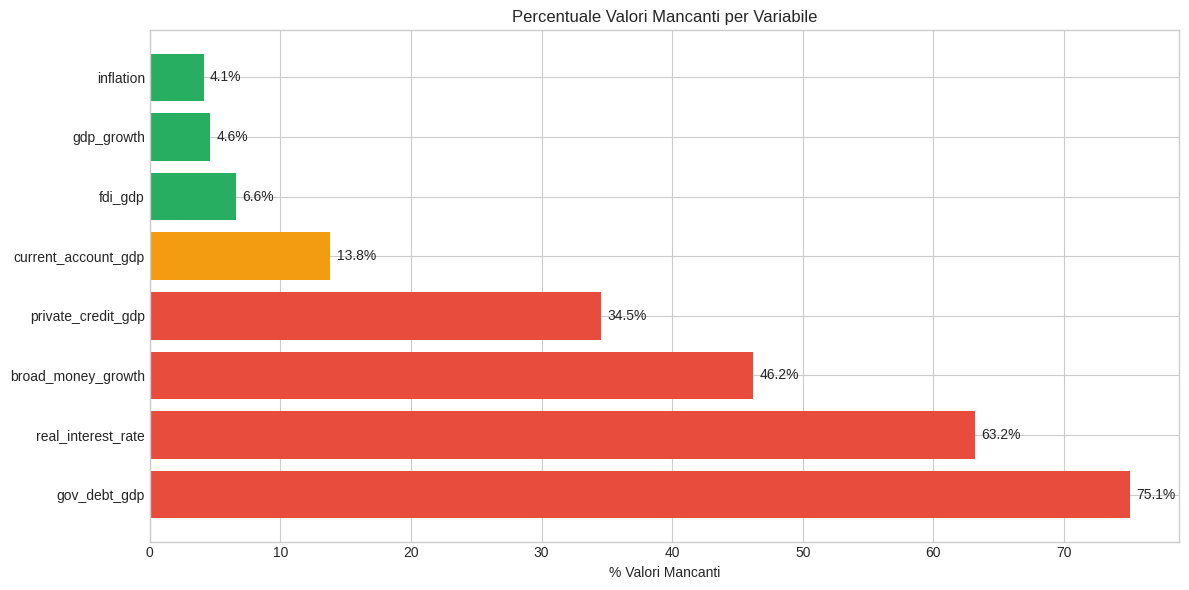

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
missing_data = df_macro[features].isnull().sum().sort_values(ascending=False)
missing_pct = (missing_data / len(df_macro) * 100)
colors = ['#e74c3c' if x > 30 else '#f39c12' if x > 10 else '#27ae60' for x in missing_pct]
bars = ax.barh(missing_data.index, missing_pct, color=colors)
ax.set_xlabel('% Valori Mancanti')
ax.set_title('Percentuale Valori Mancanti per Variabile')
for bar, pct in zip(bars, missing_pct):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', va='center')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_missing_values.png', dpi=150)
plt.show()

## 7.3 Distribuzioni e Outliers

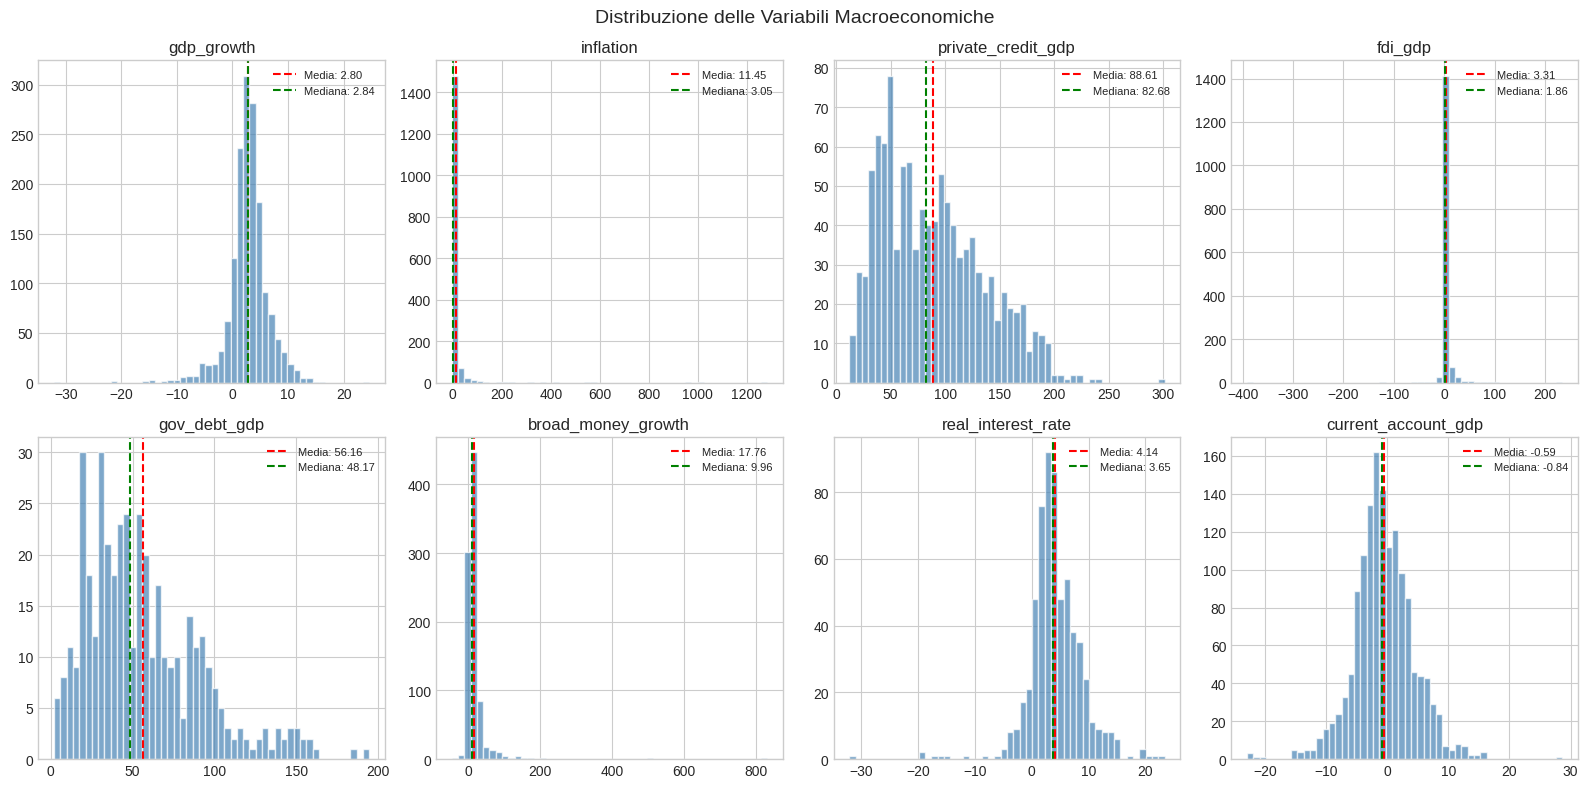

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(features):
    data = df_macro[col].dropna()
    axes[i].hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='white')
    axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'Media: {data.mean():.2f}')
    axes[i].axvline(data.median(), color='green', linestyle='--', label=f'Mediana: {data.median():.2f}')
    axes[i].set_title(col)
    axes[i].legend(fontsize=8)
plt.suptitle('Distribuzione delle Variabili Macroeconomiche', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_distribuzioni.png', dpi=150)
plt.show()

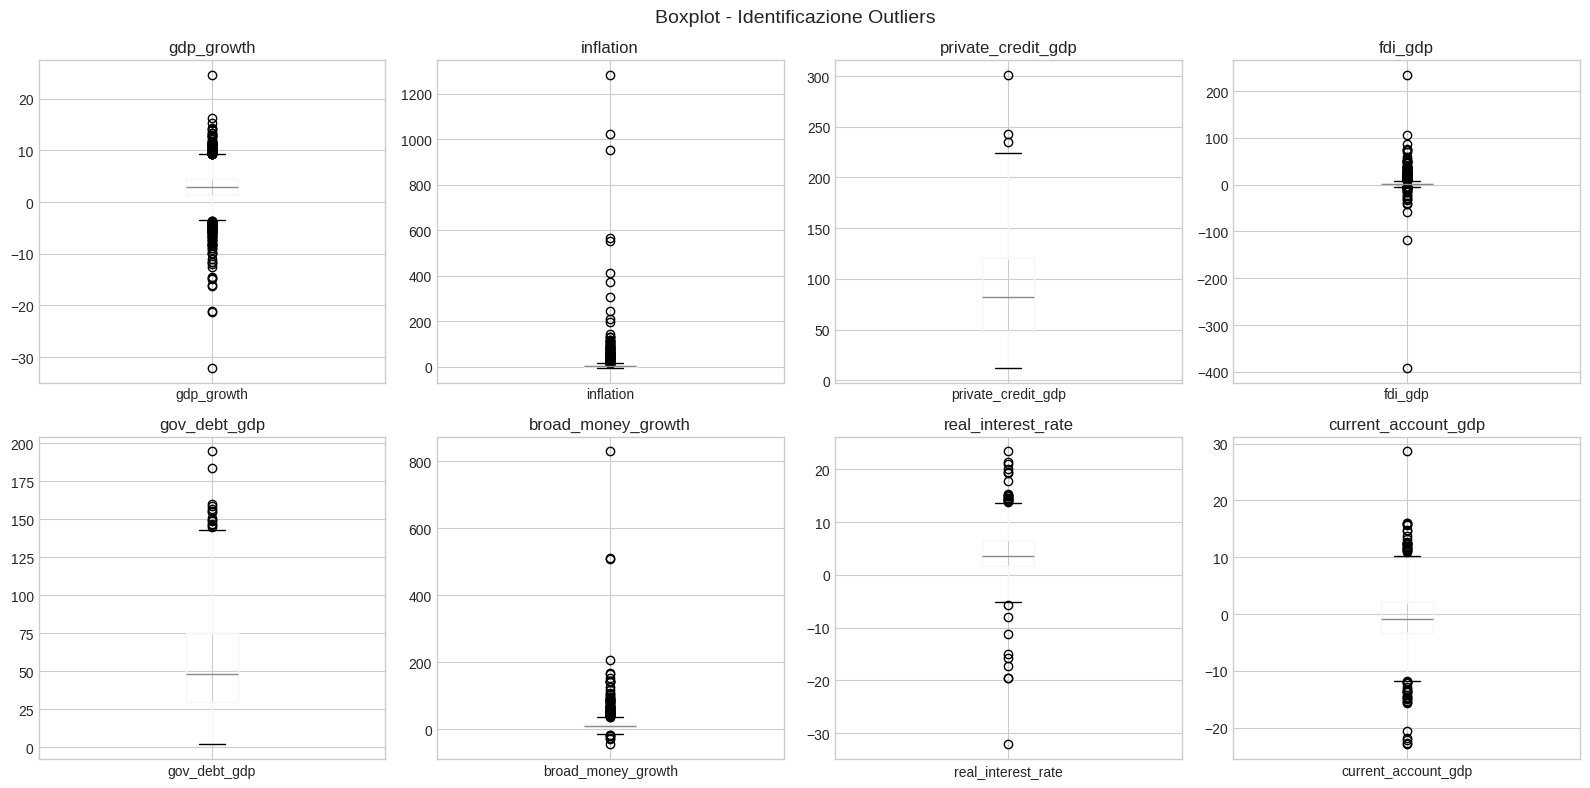

In [ ]:
# Boxplot per outliers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(features):
    df_macro.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)
plt.suptitle('Boxplot - Identificazione Outliers', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_boxplot_outliers.png', dpi=150)
plt.show()

## 7.4 Matrice di Correlazione

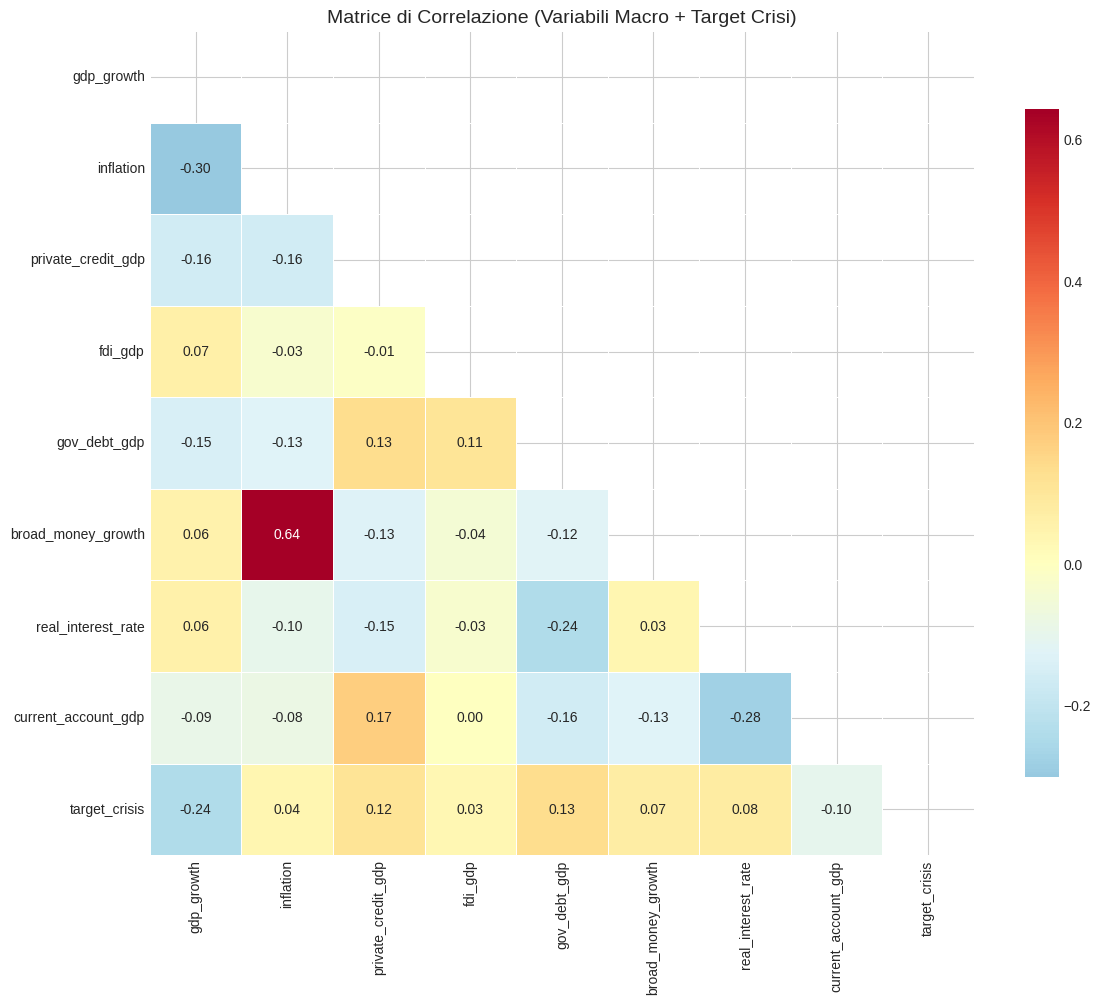


📊 Correlazioni con Target Crisi:


,target_crisis
gdp_growth,-0.241425
gov_debt_gdp,0.132399
private_credit_gdp,0.115120
current_account_gdp,-0.104091
real_interest_rate,0.075082
broad_money_growth,0.072519
inflation,0.038242
fdi_gdp,0.031927


In [ ]:
corr_matrix = df_macro[features + ['target_crisis']].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
plt.title('Matrice di Correlazione (Variabili Macro + Target Crisi)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_correlation_matrix.png', dpi=150)
plt.show()

# Correlazioni con target
print("\n📊 Correlazioni con Target Crisi:")
corr_target = corr_matrix['target_crisis'].drop('target_crisis').sort_values(key=abs, ascending=False)
display(corr_target)

## 7.5 Confronto Crisi vs Non-Crisi

In [ ]:
df_crisis_group = df_macro[df_macro['target_crisis'] == 1]
df_no_crisis = df_macro[df_macro['target_crisis'] == 0]

comparison = pd.DataFrame({
    'Media (No Crisi)': df_no_crisis[features].mean(),
    'Media (Crisi)': df_crisis_group[features].mean(),
    'Std (No Crisi)': df_no_crisis[features].std(),
    'Std (Crisi)': df_crisis_group[features].std()
})
comparison['Differenza'] = comparison['Media (Crisi)'] - comparison['Media (No Crisi)']
comparison['Diff %'] = (comparison['Differenza'] / comparison['Media (No Crisi)'].abs() * 100).round(2)

display(comparison)
comparison.to_csv(f'{OUTPUT_DIR}/06_confronto_crisi_nocrisi.csv')

,Media (No Crisi),Media (Crisi),Std (No Crisi),Std (Crisi),Differenza,Diff %
gdp_growth,3.104077,0.060069,3.605689,4.398488,-3.044007,-98.06
inflation,10.733456,17.847969,56.959558,44.410887,7.114513,66.28
private_credit_gdp,86.785313,104.644975,45.527113,55.910103,17.859662,20.58
fdi_gdp,3.151411,4.681200,15.021791,9.443535,1.529789,48.54
gov_debt_gdp,54.504546,69.260974,33.970234,42.255006,14.756428,27.07
broad_money_growth,16.760195,26.929906,39.117757,60.934149,10.169710,60.68
real_interest_rate,4.015097,5.211442,4.693910,5.815134,1.196345,29.80
current_account_gdp,-0.409440,-2.037485,4.878604,5.050728,-1.628045,-397.63


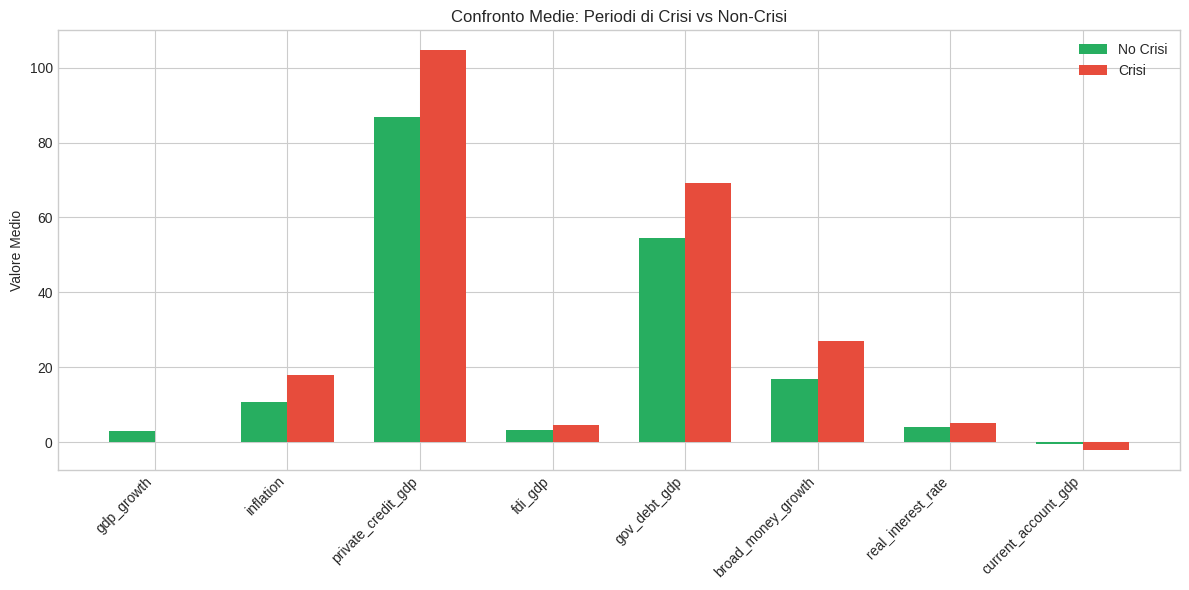

In [ ]:
# Visualizzazione confronto
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(features))
width = 0.35
bars1 = ax.bar(x - width/2, comparison['Media (No Crisi)'], width, label='No Crisi', color='#27ae60')
bars2 = ax.bar(x + width/2, comparison['Media (Crisi)'], width, label='Crisi', color='#e74c3c')
ax.set_ylabel('Valore Medio')
ax.set_title('Confronto Medie: Periodi di Crisi vs Non-Crisi')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/07_confronto_medie.png', dpi=150)
plt.show()

## 7.6 Trend Temporale

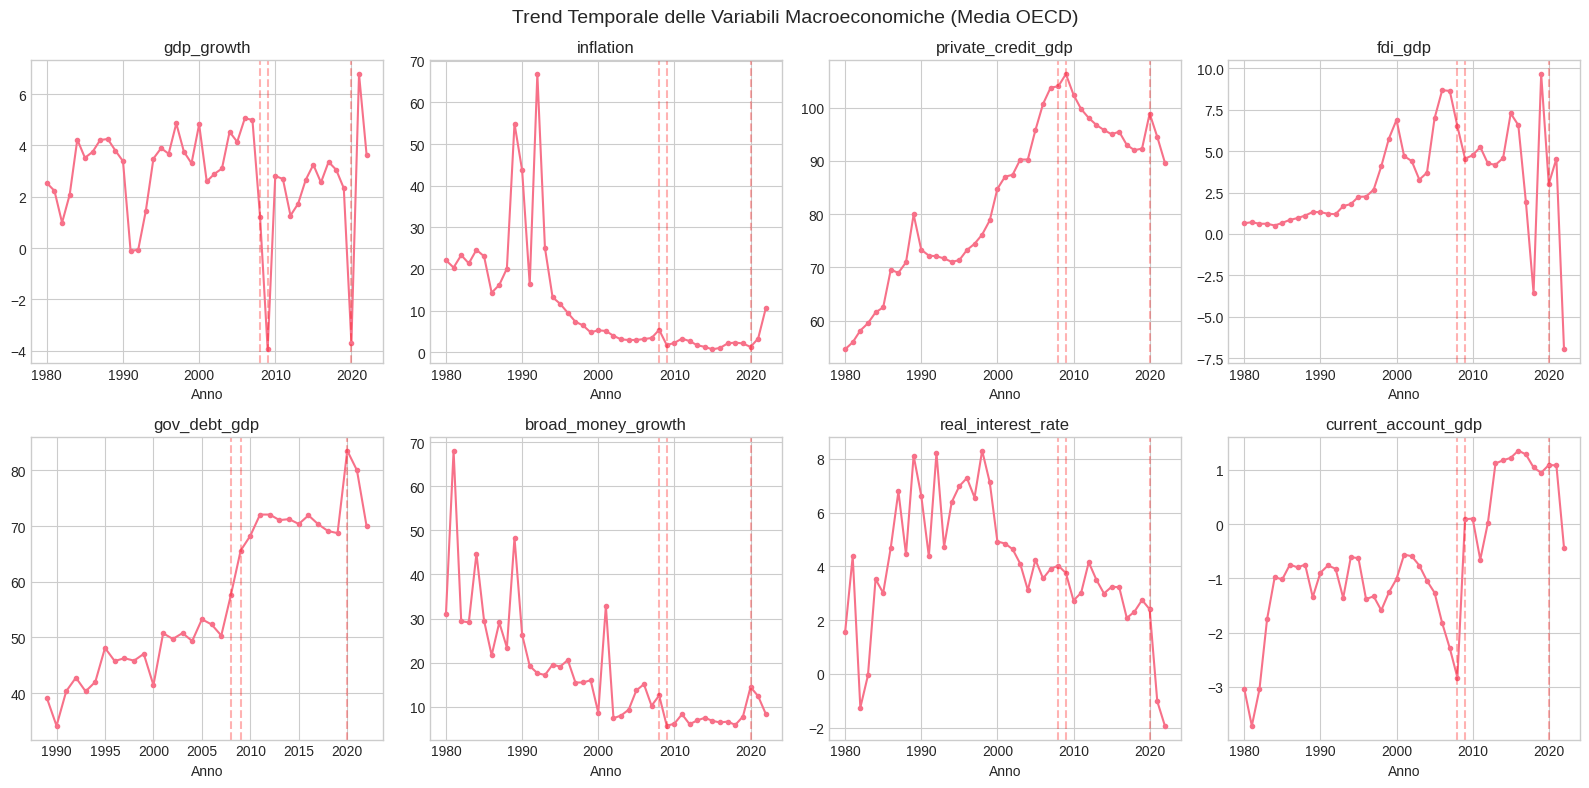

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
yearly_avg = df_macro.groupby('year')[features].mean()
for i, col in enumerate(features):
    axes[i].plot(yearly_avg.index, yearly_avg[col], marker='o', markersize=3)
    axes[i].set_title(col)
    axes[i].set_xlabel('Anno')
    # Evidenzia anni di crisi globali
    for year in [2008, 2009, 2020]:
        if year in yearly_avg.index:
            axes[i].axvline(year, color='red', alpha=0.3, linestyle='--')
plt.suptitle('Trend Temporale delle Variabili Macroeconomiche (Media OECD)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/08_trend_temporale.png', dpi=150)
plt.show()

---
# 8. FEATURE ENGINEERING AVANZATO

Creazione di features avanzate per il modello predittivo:
- **Lag multipli** (t-1, t-2, t-3)
- **Variazioni percentuali** (delta)
- **Medie mobili** (MA3, MA5)
- **Volatilità** (STD rolling)
- **Credit gap**

In [ ]:
# Ordina per paese e anno
df_macro.sort_values(by=['iso3', 'year'], inplace=True)

print("Creazione features avanzate...")

Creazione features avanzate...


## 8.1 Lag Multipli (t-1, t-2, t-3)

In [ ]:
print("Creazione lag multipli...")
for col in features:
    for lag in [1, 2, 3]:
        df_macro[f'{col}_lag{lag}'] = df_macro.groupby('iso3')[col].shift(lag)

print(f"✓ Create {len(features) * 3} features lag")

Creazione lag multipli...
✓ Create 24 features lag


## 8.2 Variazioni Percentuali

In [ ]:
print("Creazione variazioni percentuali...")
for col in features:
    # Variazione rispetto a t-1
    df_macro[f'{col}_delta1'] = df_macro.groupby('iso3')[col].pct_change(1) * 100
    # Variazione rispetto a t-2
    df_macro[f'{col}_delta2'] = df_macro.groupby('iso3')[col].pct_change(2) * 100

print(f"✓ Create {len(features) * 2} features delta")

Creazione variazioni percentuali...
✓ Create 16 features delta


## 8.3 Medie Mobili e Volatilità

In [ ]:
print("Creazione medie mobili e volatilità...")
for col in features:
    # Media mobile 3 anni
    df_macro[f'{col}_ma3'] = df_macro.groupby('iso3')[col].transform(
        lambda x: x.rolling(window=3, min_periods=2).mean()
    )
    # Media mobile 5 anni
    df_macro[f'{col}_ma5'] = df_macro.groupby('iso3')[col].transform(
        lambda x: x.rolling(window=5, min_periods=3).mean()
    )
    # Volatilità (deviazione standard rolling 3 anni)
    df_macro[f'{col}_std3'] = df_macro.groupby('iso3')[col].transform(
        lambda x: x.rolling(window=3, min_periods=2).std()
    )

print(f"✓ Create {len(features) * 3} features MA e volatilità")

Creazione medie mobili e volatilità...
✓ Create 24 features MA e volatilità


## 8.4 Credit Gap

In [ ]:
print("Creazione Credit Gap...")
# Usiamo una media mobile lunga come proxy del trend
df_macro['credit_trend'] = df_macro.groupby('iso3')['private_credit_gdp'].transform(
    lambda x: x.rolling(window=10, min_periods=5).mean()
)
df_macro['credit_gap'] = df_macro['private_credit_gdp'] - df_macro['credit_trend']
df_macro['credit_gap_pct'] = (df_macro['credit_gap'] / df_macro['credit_trend']) * 100

print("✓ Create features credit_gap")

Creazione Credit Gap...
✓ Create features credit_gap


## 8.5 Interazioni Chiave

In [ ]:
print("Creazione interazioni...")
# Credito alto + tassi in salita = rischio
df_macro['credit_x_rate'] = df_macro['private_credit_gdp'] * df_macro['real_interest_rate']
# Inflazione alta + crescita bassa = stagflazione
df_macro['inflation_minus_growth'] = df_macro['inflation'] - df_macro['gdp_growth']

print("✓ Create features interazione")
print(f"\n📊 Numero totale di features create: {df_macro.shape[1] - 5}")

Creazione interazioni...
✓ Create features interazione

📊 Numero totale di features create: 76


---
# 9. TARGET EARLY WARNING (t+1, t+2)

Creiamo target anticipati per predire le crisi **prima** che accadano.

In [ ]:
print("Creazione target anticipati per early warning...")

# Target t+1: crisi nell'anno SUCCESSIVO
df_macro['target_crisis_t1'] = df_macro.groupby('iso3')['target_crisis'].shift(-1)

# Target t+2: crisi in 2 anni
df_macro['target_crisis_t2'] = df_macro.groupby('iso3')['target_crisis'].shift(-2)

# Target t+3: crisi in 3 anni
df_macro['target_crisis_t3'] = df_macro.groupby('iso3')['target_crisis'].shift(-3)

# Target "crisi imminente" (entro 1-2 anni)
df_macro['target_crisis_1_2y'] = ((df_macro['target_crisis_t1'] == 1) |
                                   (df_macro['target_crisis_t2'] == 1)).astype(int)

print("\n📊 Distribuzione Target (crisi nell'anno t+1):")
print(df_macro['target_crisis_t1'].value_counts(dropna=False))

print("\n📊 Distribuzione Target (crisi entro 2 anni):")
print(df_macro['target_crisis_1_2y'].value_counts(dropna=False))

Creazione target anticipati per early warning...

📊 Distribuzione Target (crisi nell'anno t+1):
target_crisis_t1
0.0    1477
1.0     161
NaN      39
Name: count, dtype: int64

📊 Distribuzione Target (crisi entro 2 anni):
target_crisis_1_2y
0    1473
1     204
Name: count, dtype: int64


---
# 10. MODELLO EARLY WARNING

Costruiamo e confrontiamo diversi modelli di machine learning per predire le crisi bancarie.